In [229]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
import sys
sys.path.insert(0, '../scripts/')

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from datetime import datetime, timedelta
from plots import Plots
from data_cleaning import DataCleaner
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from joblib import dump
import bisect
import datetime
%matplotlib inline

In [232]:
pwd = os.getcwd()

train_file_path = os.path.join(pwd, os.pardir, "data/train_clean.csv")
test_file_path = os.path.join(pwd, os.pardir, "data/test_clean.csv")
store_file_path = os.path.join(pwd, os.pardir, "data/store_clean.csv")

In [233]:
df_train = pd.read_csv(train_file_path, dtype={'StateHoliday': object}, parse_dates=["Date"])
df_test = pd.read_csv(test_file_path, dtype={'StateHoliday': object}, parse_dates=["Date"])
df_store = pd.read_csv(store_file_path)

In [234]:
df_train_store = pd.merge(df_train, df_store, how = 'left', on = 'Store')
df_test_store = pd.merge(df_test, df_store, how = 'left', on = 'Store')

In [235]:
df_train_store["Weekday"] = df_train_store.apply(lambda x: 1 if x["DayOfWeek"] >= 5 else 0, axis=1)

In [236]:
def dateToAndAfterHoliday(df,Column,holidays):
    to=[]
    after=[]
    for a in df[Column]:
        index=bisect.bisect(holidays,a)
        if len(holidays)==index:
            to.append(pd.Timedelta(0, unit='d') )
            after.append(a - holidays[index-1])
        else:
            after.append(holidays[index] - a)
            to.append(a -holidays[index-1])
    return to, after

In [237]:
dates = np.array(df_train_store.loc[df_train_store["StateHoliday"] != "0"]["Date"].unique())
df_train_store["To"], df_train_store["After"] = dateToAndAfterHoliday(df_train_store, "Date", dates)

In [238]:
df_train_store["To"] = pd.to_numeric(df_train_store['To'].dt.days, downcast='integer')
df_train_store["After"] = pd.to_numeric(df_train_store['After'].dt.days, downcast='integer')

In [239]:
def startMidEndMonth(x):
    if x.day <10:
        return 0
    elif x.day <20:
        return 1
    else:
        return 2

In [240]:
df_train_store["MonthState"] = df_train_store["Date"].apply(startMidEndMonth)

In [241]:
data_cleaner_train = DataCleaner(df_train_store)

In [242]:
data_cleaner_train.remove_closed_stores()

In [243]:
data_cleaner_train.remove_outliers("Sales")

<AxesSubplot:ylabel='Frequency'>

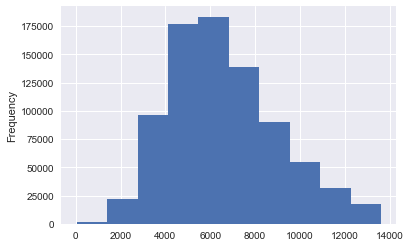

In [244]:
data_cleaner_train.dataframe["Sales"].plot(kind="hist")

In [245]:
label_encoder = LabelEncoder()

In [247]:
data_cleaner_train.dataframe["StateHoliday"] = label_encoder.fit_transform(data_cleaner_train.dataframe["StateHoliday"])
data_cleaner_train.dataframe["PromoInterval"] = label_encoder.fit_transform(data_cleaner_train.dataframe["PromoInterval"])

In [248]:
data_cleaner_train.scale_dataframe()

In [249]:
scaled_df_train = data_cleaner_train.dataframe

In [250]:
scaled_df_train

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Weekday,To,After,MonthState
0,-1.723137,0.848235,-0.546063,-0.535808,0.0,1.137629,-0.027680,2.049443,-0.541901,0.948218,0.683667,-1.013415,-0.766266,-1.013415,0.045384,1.384622,-0.802179,1.859428,1.123134
1,-1.720041,0.848235,-0.215209,-0.306968,0.0,1.137629,-0.027680,2.049443,-0.631367,1.414336,0.682599,0.986762,0.082140,0.985015,0.045384,1.384622,-0.802179,1.859428,1.123134
2,-1.716946,0.848235,0.714155,0.333785,0.0,1.137629,-0.027680,2.049443,1.101715,1.647395,0.681531,0.986762,0.147402,0.986009,0.045384,1.384622,-0.802179,1.859428,1.123134
3,-1.710755,0.848235,-0.728218,-0.522732,0.0,1.137629,-0.027680,2.049443,3.118531,-0.217078,0.691144,-1.013415,-0.766266,-1.013415,0.045384,1.384622,-0.802179,1.859428,1.123134
4,-1.707660,0.848235,-0.385799,-0.424657,0.0,1.137629,-0.027680,2.049443,-0.664597,1.647395,0.689008,-1.013415,-0.766266,-1.013415,0.045384,1.384622,-0.802179,1.859428,1.123134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813564,0.384777,-0.901732,-1.325903,-0.499848,0.0,-0.879021,22.928481,2.049443,-0.685046,0.948218,0.681531,-1.013415,-0.766266,-1.013415,0.045384,-0.722219,-0.802179,1.455147,-1.350611
813565,0.542639,-0.901732,1.726543,5.420577,0.0,-0.879021,22.928481,2.049443,-0.594302,1.181277,0.674054,-1.013415,-0.766266,-1.013415,0.045384,-0.722219,-0.802179,1.455147,-1.350611
813566,0.654070,-0.901732,-0.640239,1.729710,0.0,-0.879021,22.928481,2.049443,-0.596858,-1.149315,-1.461092,0.986762,2.366310,0.987003,0.045384,-0.722219,-0.802179,1.455147,-1.350611
813567,1.208133,-0.901732,-0.864938,1.046459,0.0,-0.879021,22.928481,2.049443,-0.521451,-1.149315,-1.461092,-1.013415,-0.766266,-1.013415,0.045384,-0.722219,-0.802179,1.455147,-1.350611


In [251]:
X = scaled_df_train
y = scaled_df_train.drop(columns=["Sales"], axis=1)

In [252]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2)

In [253]:
regressor = RandomForestRegressor(n_estimators=10, max_depth=16, n_jobs=-1)

In [254]:
regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_estimators=10, n_jobs=-1)

In [255]:
y_pred = regressor.predict(X_test)

In [256]:
score = regressor.score(X_train, y_train)
print("R-squared:", score)

R-squared: 0.9631744527994613


In [257]:
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0))

MSE:  0.04451154241165513
RMSE:  0.022255771205827564


In [258]:
model_timestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
model_file_path = os.path.join(pwd, os.pardir, 'models')

In [259]:
dump(filename=f'{model_file_path}/{model_timestamp}.pkl', value=regressor, compress=9)

['c:\\Users\\user\\Desktop\\10_Academy\\Week_3\\Technical\\Pharmaceutical-Sales\\notebooks\\..\\models/2022-05-28-17-13-16.pkl']

In [260]:
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": regressor.feature_importances_})

In [261]:
feature_importance

,Feature,Importance
0,Store,0.054218
1,DayOfWeek,0.088075
2,Sales,0.001093
3,Customers,0.046477
4,Open,0.000000
5,Promo,0.061830
6,StateHoliday,0.059740
7,SchoolHoliday,0.061742
8,CompetitionDistance,0.055683
9,CompetitionOpenSinceMonth,0.076651


In [262]:
plt.style.use('seaborn')

<AxesSubplot:title={'center':'Feature Importance'}, ylabel='Feature'>

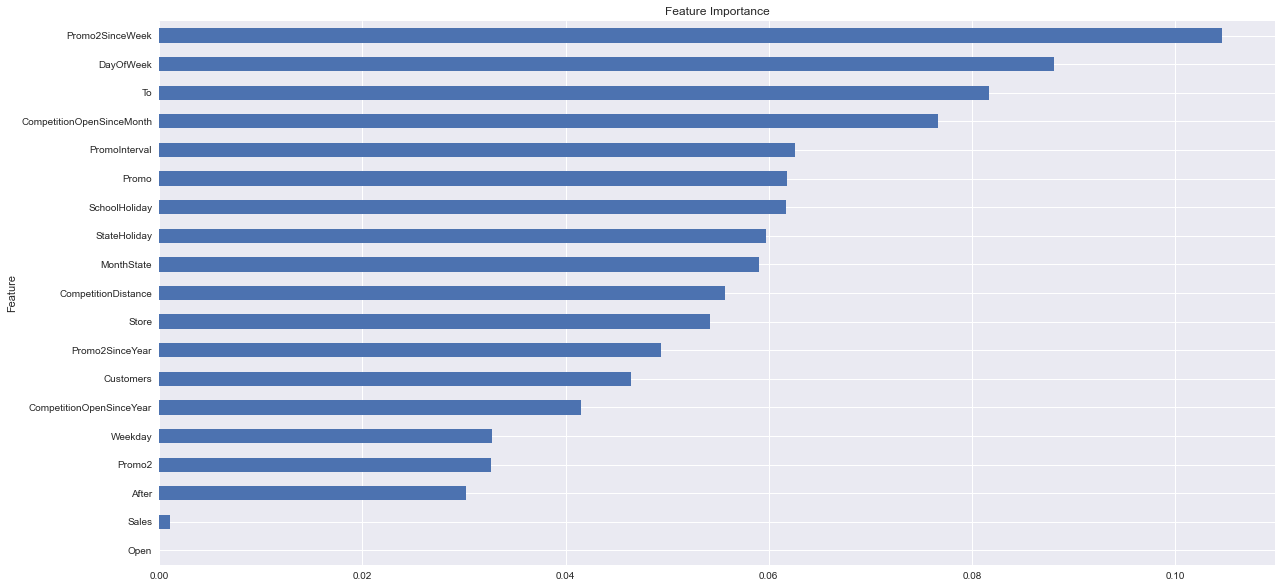

In [263]:
feature_importance.sort_values(by="Importance").plot(kind="barh", x="Feature", y="Importance", title="Feature Importance", legend=False, figsize=(20, 10))